# Árboles de decisión 

### Librerias

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

### Data

In [2]:
data = pd.read_csv("D:/DATASET/Iris.csv")
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
data.drop("Id", axis=1, inplace=True)           #Borrar columna innecesaria 

### Dimensiones

In [4]:
data.shape                  

(150, 5)

> 5 Variables (incluyendo Target)

> 150 casos

# Exploración de los datos

### Missing Values

In [22]:
data.isna().sum()              #No hay valores nulos 

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

### Correlaciones lineales

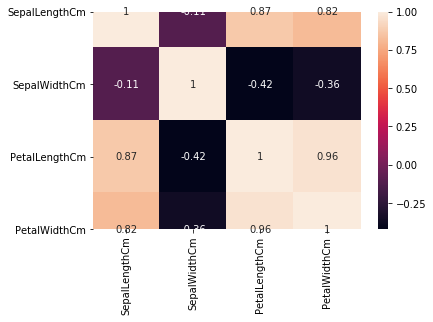

In [19]:
corr_matrix = data.corr()
ax = sns.heatmap(corr_matrix, annot=True)

In [9]:
def top_correlation (df,n):
    corr_matrix = df.corr()
    correlation = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
    correlation = pd.DataFrame(correlation).reset_index()
    correlation.columns=["Variable_1","Variable_2","Correlacion"]
    correlation = correlation.reindex(correlation.Correlacion.abs().sort_values(ascending=False).index).reset_index().drop(["index"],axis=1)
    return correlation.head(n)
    
top_correlation(data,10)

,Variable_1,Variable_2,Correlacion
0,PetalLengthCm,PetalWidthCm,0.962757
1,SepalLengthCm,PetalLengthCm,0.871754
2,SepalLengthCm,PetalWidthCm,0.817954
3,SepalWidthCm,PetalLengthCm,-0.420516
4,SepalWidthCm,PetalWidthCm,-0.356544
5,SepalLengthCm,SepalWidthCm,-0.109369


> Hay 4 variables de las cuales 3 de ellas estan muy correlacionadas entre sí 

> La variable SepalWidthCm es la que menos correlaciona con las otras

### Distribución de los datos 

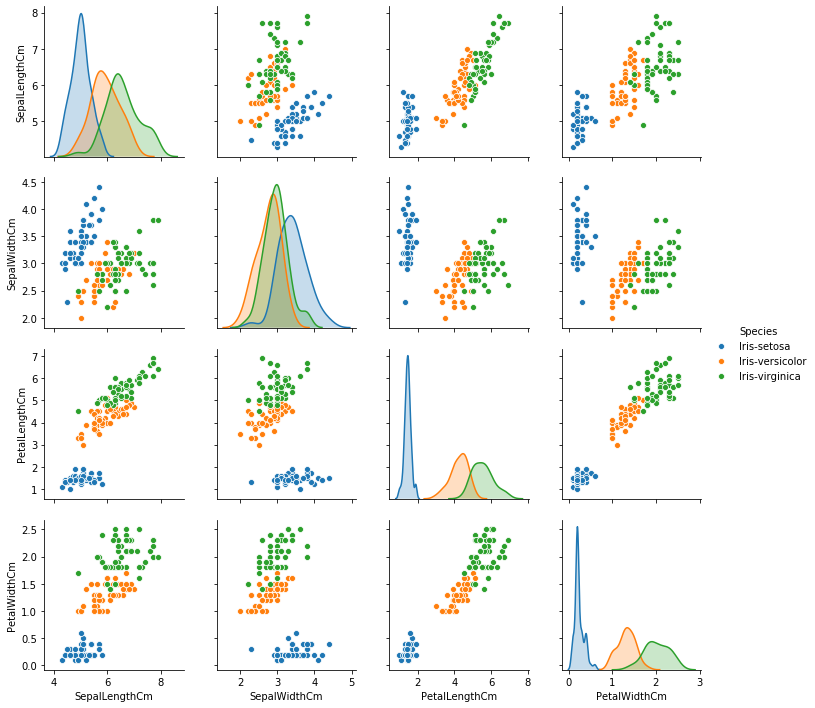

In [18]:
sns.pairplot(data, hue = "Species");

> La Iris Setosa resulta fácil de diferenciar en todas las distribuciones 

# Selección de Variables 

### Separar variable objetivo

In [84]:
X = data.drop("Species",axis=1)
Y = data.Species
X_columnas = X.columns

In [85]:
#Dividir en test/train
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

## Clasificación: Árbol de decisión

In [86]:
#MODELO: ARBOL DE DECISIÓN
from sklearn import tree

model = tree.DecisionTreeClassifier()
model = model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)

print(model.score(X_test,Y_test))

pd.crosstab(Y_test,Y_pred)




0.9777777777777777


col_0,Iris-setosa,Iris-versicolor,Iris-virginica
Species,,,
Iris-setosa,16,0,0
Iris-versicolor,0,17,1
Iris-virginica,0,0,11


> Se obtiene un Accuracy de 97,7% en Test

> La matriz de confusión muestra como el modelo solo se ha equivocado una vez: Clasifica una Versicolor como Virginica

- Evaluar Modelo

In [71]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(decision_tree, X_train, Y_train,cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.11)


> Siendo mas exigentes, se aplica una validación cruzada donde se obtiene un Accuracy de 94% y desviación de 0.11

- Graficar Modelo

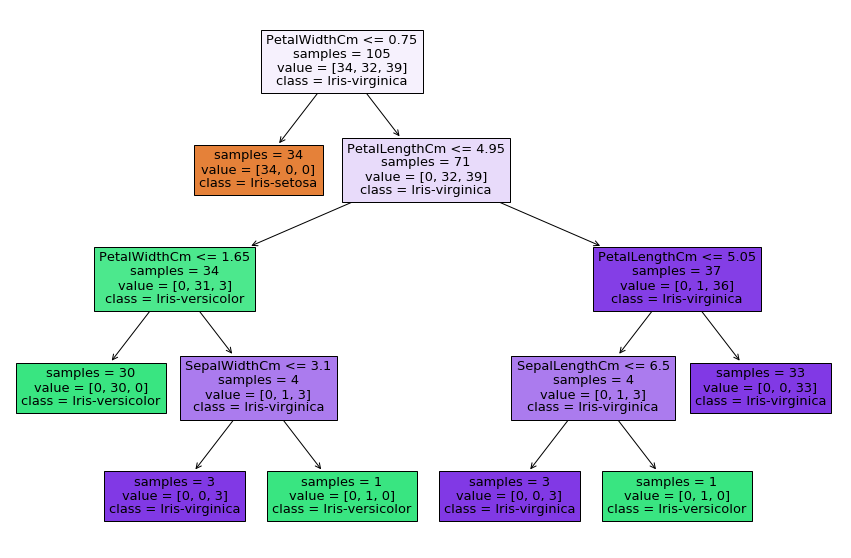

In [87]:
plt.figure(figsize=(15,10))
tree.plot_tree(model, filled=True, class_names=Y.unique(), feature_names=X_columnas, impurity=False)
plt.show()

> Aqui se observan los pasos tomados por el modelo para clasificar las plantas

> La iris setosa es la más fácil de clasificar; todas aquellas que tengan un PetalWidthCm <= 0.75 son Setosa

In [93]:
data[data["PetalWidthCm"]<=0.75].Species.unique()

array(['Iris-setosa'], dtype=object)

> Efectivamente, al aplicar el filtro la clasificación es perfecta

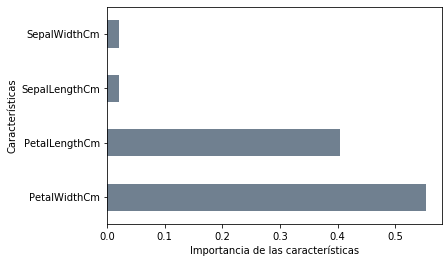

In [94]:
#Importancia de cada variable 
feat_importances = pd.Series(model.feature_importances_, index=X_columnas)
feat_importances.nlargest(5).plot(kind='barh', color="slategrey")
plt.xlabel('Importancia de las características')
plt.ylabel('Características')
plt.show()

> Sin embargo en el modelo se aprecia que para la toma de decisiónes se basa practicamente en solo dos variables, esto sugiere que las otras dos no aportan suficiente información y que el modelo podría mejorar realizando una selección de features

## Reducción de dimensión 

> Al estar tan correlacionadas entre sí y tratarse de variables cuantitativas, aplicar un PCA puede ser idóneo

- Escalado de Variables

In [97]:
# Escalado de variables: Muy recomendado antes del PCA 
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

### PCA 

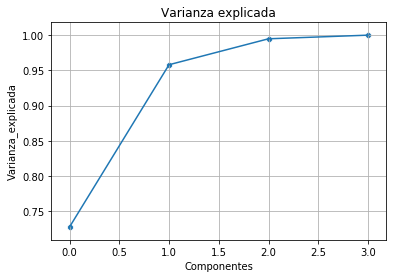

In [45]:
# ELEGIR NUMERO DE COMPONENTES 
from sklearn.decomposition import PCA
pca = PCA(n_components = None)              
pca.fit(X)
varianza_explicada = pd.DataFrame(pca.explained_variance_ratio_).cumsum()

#Varianza que explica cada componente: A medida que aumentan los componentes se reduce la varianza explicada

# Elbow Method
a = varianza_explicada.reset_index()
sns.lineplot(x=a["index"], y =a[0])
sns.scatterplot(x=a["index"], y =a[0])
plt.title('Varianza explicada')
plt.xlabel('Componentes')
plt.ylabel('Varianza_explicada')
plt.grid()
plt.show()

> Con 2 componentes se sigue explicando un 99% de la varianza, reduciendo de 4 a dos variables.

In [98]:
# ELEGIR NUMERO DE COMPONENTES 
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)                  
X_PCA = pd.DataFrame(pca.fit_transform(X))
X_PCA.head(5)

,0,1
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767


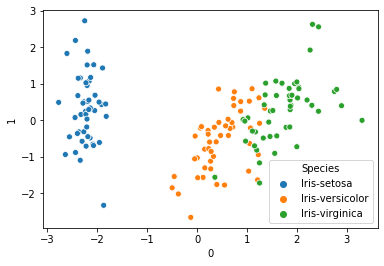

In [57]:
sns.scatterplot(x = X_PCA[0], y = X_PCA[1], hue = Y);

### Clasificación: Árbol de decisión después de  PCA

In [127]:
#MODELO: ARBOL DE DECISIÓN
from sklearn import tree
model = tree.DecisionTreeClassifier()

# Validación cruzada 
from sklearn.model_selection import cross_val_score

score = cross_val_score(model, X_PCA,Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.88 (+/- 0.13)


> Al reducir el nº de variables a usar el Accuracy se reduce en 7 pts y aumenta ligeramente la varianza. 

> Pese a que se reduce el nº de variables en un 50% acambio de reducir el Accuracy en 7 pts dada la simplicidad del modelo baseline resulta innecesario realizar el PCA; es matar moscas a cañonazos

### Clasificación: Árbol de decisión con feature selection

> Simplemente seleccionando las dos variables que mas importancias tuvieron en el modelo baseline:

In [131]:
X_new = data[["PetalLengthCm","PetalWidthCm"]]

In [140]:
#MODELO: ARBOL DE DECISIÓN
from sklearn import tree
model = tree.DecisionTreeClassifier()

# Validación cruzada 
from sklearn.model_selection import cross_val_score

score = cross_val_score(model, X_new,Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.95 (+/- 0.07)


> Se obtiene el mejor Accuracy con la mejor reducción de desviación (a la mitad)